In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
import datetime

In [ ]:
data= pd.read_csv('bitcoin_2022.csv')
data.head()

,Date,Open*,High,Low,Close**,Volume,Market Cap
0,07-Feb-22,42406.78,44401.86,41748.16,43840.29,28641855926,8.308390e+11
1,08-Feb-22,43854.65,45293.87,42807.84,44118.45,33079398868,8.361550e+11
2,09-Feb-22,44096.70,44727.80,43232.97,44338.80,23245887300,8.403690e+11
3,10-Feb-22,44347.80,45661.17,43402.81,43565.11,32142048537,8.257450e+11
4,11-Feb-22,43571.13,43810.83,42114.54,42407.94,26954925781,8.038480e+11


In [ ]:
high_prices = data['High'].values
low_prices = data['Low'].values
mid_prices = (high_prices + low_prices) / 2

In [ ]:
seq_len = 10
sequence_length = seq_len+1

result=[]
for index in range(len(mid_prices) - sequence_length):
  result.append(mid_prices[index: index + sequence_length])

In [ ]:
def normalize_windows(data):
    normalized_data = []
    for window in data:
        normalized_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalized_data.append(normalized_window)
    return np.array(normalized_data)

result = normalize_windows(result)

row = int(round(result.shape[0] * 0.9))
train = result[:row, :]
np.random.shuffle(train)

In [ ]:
x_train=train[:,:-1]
x_train=np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))
y_train = train[:, -1]

x_test = result[row:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = result[row:, -1]

x_train.shape, x_test.shape

((104, 10, 1), (12, 10, 1))

In [ ]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(10,1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer='rmsprop')
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 10, 50)            10400     
                                                                 
 lstm_5 (LSTM)               (None, 64)                29440     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 39,905
Trainable params: 39,905
Non-trainable params: 0
_________________________________________________________________


In [ ]:
start_time = datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')

model.fit(x_train, y_train,
          validation_data = (x_test, y_test),
          batch_size=10,
          epochs=20,
          callbacks=[TensorBoard(log_dir='logs/%s' % (start_time)), ModelCheckpoint('./models/%s_eth.h5' % (start_time), monitor='val_loss', verbose=1, save_best_only=True, mode='auto'), ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, mode='auto')
                     
          ])

Epoch 1/20
11/11 [==============================] - ETA: 0s - loss: 0.0077
Epoch 1: val_loss improved from inf to 0.00124, saving model to ./models/2022_06_14_16_44_33_eth.h5
11/11 [==============================] - 5s 99ms/step - loss: 0.0077 - val_loss: 0.0012 - lr: 0.0010
Epoch 2/20
11/11 [==============================] - ETA: 0s - loss: 0.0043
Epoch 2: val_loss did not improve from 0.00124
11/11 [==============================] - 0s 17ms/step - loss: 0.0043 - val_loss: 0.0013 - lr: 0.0010
Epoch 3/20
10/11 [==========================>...] - ETA: 0s - loss: 0.0035
Epoch 3: val_loss did not improve from 0.00124
11/11 [==============================] - 0s 17ms/step - loss: 0.0037 - val_loss: 0.0015 - lr: 0.0010
Epoch 4/20
10/11 [==========================>...] - ETA: 0s - loss: 0.0035
Epoch 4: val_loss did not improve from 0.00124
11/11 [==============================] - 0s 17ms/step - loss: 0.0035 - val_loss: 0.0018 - lr: 0.0010
Epoch 5/20
10/11 [==========================>...] - ETA

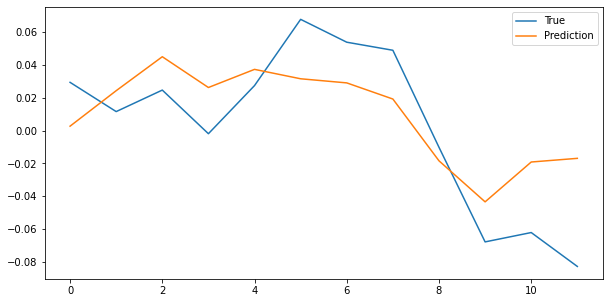

In [ ]:
pred = model.predict(x_test)

fig=plt.figure(facecolor='white', figsize=(10,5))
ax=fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(pred, label='Prediction')
ax.legend()
plt.show()